# Acknowledgement
Find the dataset here https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
## Dataset Content
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

Dataset has more pneumonia images than normal imgaes and therefore focus must be on precision
## Note: Do not run this notebook on PC with RAM less than 13GB

# Importing packages

In [ ]:
import gc
import cv2
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.metrics import confusion_matrix,precision_score,recall_score

sns.set(font_scale=1.4)
#base image path in kaggle env
BASE_IMAGE_PATH = Path('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/')
#Reshape input images to 200x200, free to be changed
IMG_SIZE=200

# Helper functions

In [2]:
#returns image path of a set of data, train, test and val
def get_imgs_path(cat):
    PATH = BASE_IMAGE_PATH / cat
    normal_path = PATH / 'NORMAL'
    pneumonia_path = PATH / 'PNEUMONIA'
    normal_imgs_path = normal_path.glob('*.jpeg')
    pneumonia_imgs_path = pneumonia_path.glob('*.jpeg')
    normal_imgs = [path for path in normal_imgs_path]
    pneumonia_imgs = [path for path in pneumonia_imgs_path]
    print('\n{} normal images in {} directory'.format(len(normal_imgs),cat))
    print('{} pneumonia images in {} directory\n'.format(len(pneumonia_imgs),cat))
    return normal_imgs,pneumonia_imgs

#return images and labels from given path
def get_images(normal_imgs_path,pneumonia_imgs_path):
    normal_images=[]
    normal_labels=[]
    for image_path in normal_imgs_path:
        img = cv2.imread(str(image_path))
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        if img.shape[2]==1:
            img = np.dstack([img, img, img])
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img/255.0
        img  = img.astype(np.float32)
        normal_images.append(img)
        normal_labels.append(0)

    for image_path in pneumonia_imgs_path:
        img = cv2.imread(str(image_path))
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        if img.shape[2]==1:
            img = np.dstack([img, img, img])
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img/255.0
        img  = img.astype(np.float32)
        normal_images.append(img)
        normal_labels.append(1)
    return np.array(normal_images),np.array(normal_labels)

#Function for garbage collection
def clean(x):
    x=0
    gs.collect()

# Preprocess data

In [3]:
#Ready all 3 sets of data
normal_train_path,pneumonia_train_path = get_imgs_path('train')
train_images,train_labels=get_images(normal_train_path,pneumonia_train_path)
print("Shape of train_images is {}".format(train_images.shape))
print("Shape of train_labels is {}".format(train_labels.shape))

normal_val_path,pneumonia_val_path = get_imgs_path('val')
val_images,val_labels=get_images(normal_val_path,pneumonia_val_path)
print("Shape of val_images is {}".format(val_images.shape))
print("Shape of val_labels is {}".format(val_labels.shape))


normal_test_path,pneumonia_test_path = get_imgs_path('test')
test_images,test_labels=get_images(normal_test_path,pneumonia_test_path)
print("Shape of test_images is {}".format(test_images.shape))
print("Shape of test_labels is {}".format(test_labels.shape))


1341 normal images in train directory
3875 pneumonia images in train directory

Shape of train_images is (5216, 200, 200, 3)
Shape of train_labels is (5216,)

8 normal images in val directory
8 pneumonia images in val directory

Shape of val_images is (16, 200, 200, 3)
Shape of val_labels is (16,)

234 normal images in test directory
390 pneumonia images in test directory

Shape of test_images is (624, 200, 200, 3)
Shape of test_labels is (624,)


### Training data is imbalanced with almost 3 times more images for pneumonia, it can be tackled by
* Define class_weights for both classes(implemented below)
![](https://ibb.co/p28tKGQ)
* Undersample or Oversample
![](https://www.researchgate.net/profile/Peter_Andrews/publication/47349648/figure/fig1/AS:601708375834630@1520469864800/Demonstration-of-the-over-sample-and-under-sample-method-for-covariate-adjustment.png)
* Use ensemble techniques
![](https://miro.medium.com/max/3064/0*XJx4UK_LVNTx0aaI.)

# Plotting images

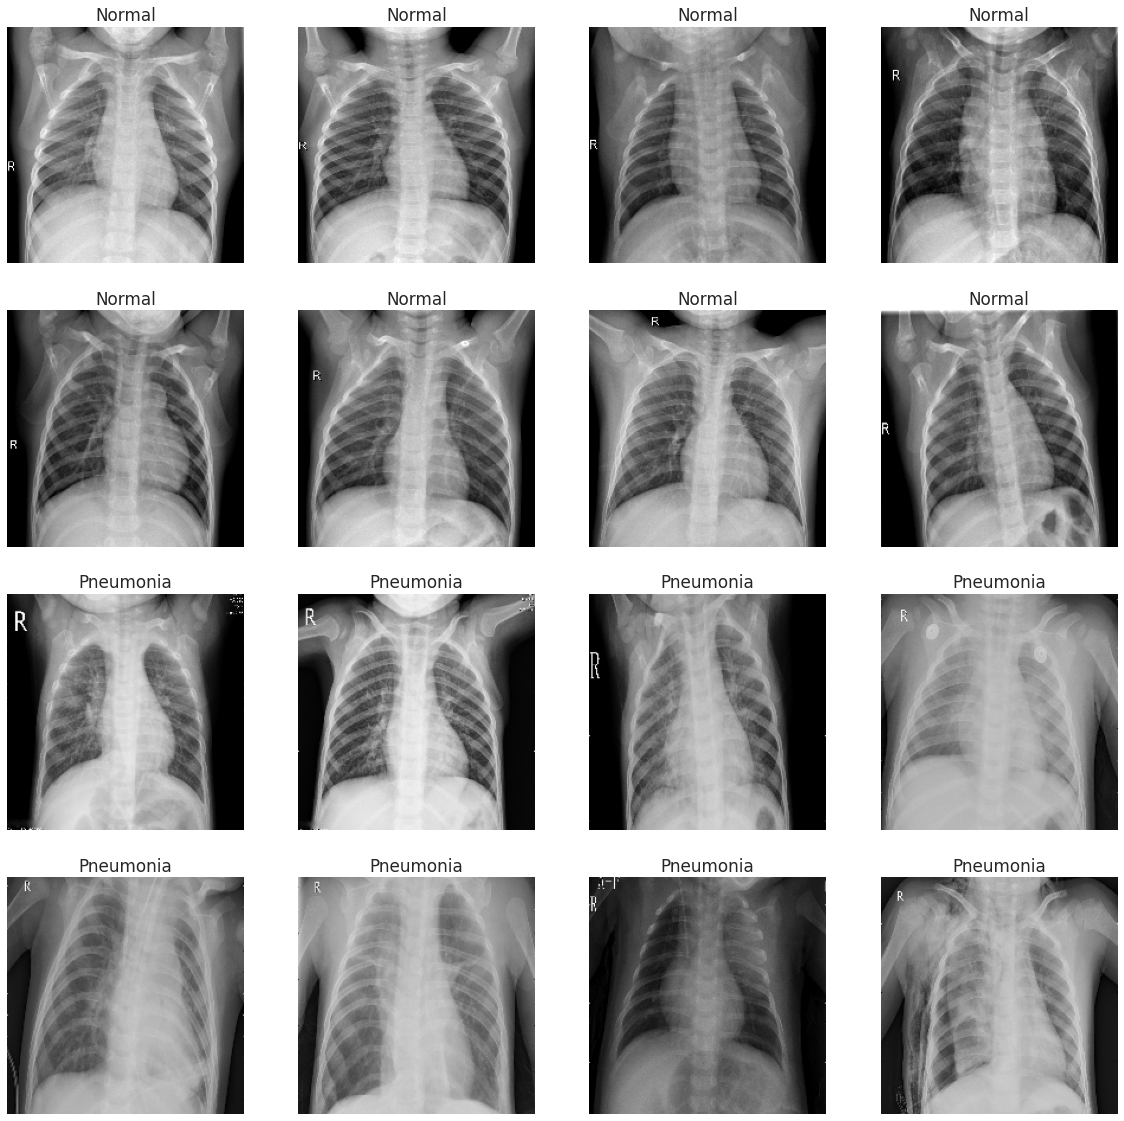

In [4]:
f = plt.figure(figsize=(20,20))
for i in range(1,17):
    ax = f.add_subplot(4,4,i)
    if i>=9:
        i += 1341
        ax.set_title('Pneumonia')
    else:
        ax.set_title('Normal')
    plt.imshow(train_images[i,:,:,:])
    ax.axis('off')

### Classifying these images would be a difficult task because even I can't tell the difference in some cases!!! Let's see how our model performs.

In [5]:
#define focal loss function which works best for imbalanced classification
#Refer to original paper here https://arxiv.org/pdf/1708.02002.pdf
from keras import backend as K
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

# Define CNN model

![](https://www.researchgate.net/profile/Takio_Kurita/publication/320748406/figure/download/fig1/AS:555719381274624@1509505233044/An-example-of-CNN-architecture.png)
### The architecture will be simple because after trying more complex architectures results are more biased towards classifying image as pneumonia.
* Conv(16)
* MaxPool()
* Conv(32)
* MaxPool()
* Conv(64)
* MaxPool()
* Conv(128)
* MaxPool()
* Conv(256)
* MaxPool()
* Dense(256)
* Dropout(0.6)
* Dense(1)

In [6]:
#opt = tf.keras.optimizers.Adadelta(lr=0.0001)
#es = EarlyStopping(patience=5)
#ckpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16,activation='relu',kernel_size=(3,3),padding='same',input_shape=(IMG_SIZE,IMG_SIZE,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=32,activation='relu',padding='same',kernel_size=(3,3)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=64,activation='relu',padding='same',kernel_size=(3,3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=128,activation='relu',padding='same',kernel_size=(3,3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=256,activation='relu',padding='same',kernel_size=(3,3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(loss=focal_loss(),optimizer='adadelta',metrics=['accuracy'])

# Train and Evaluate

In [14]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(train_labels),train_labels)
class_weights = dict(enumerate(class_weights))
history1 =  model.fit(train_images, train_labels.astype(np.float32), batch_size=16, epochs=50,
                      validation_data=(val_images,val_labels.astype(np.float32)),class_weight=class_weights, 
                      verbose=1)

Train on 5216 samples, validate on 16 samples
Epoch 1/50
5216/5216 [==============================] - 6s 1ms/sample - loss: 0.1245 - accuracy: 0.4316 - val_loss: 0.1294 - val_accuracy: 0.5000
Epoch 2/50
5216/5216 [==============================] - 5s 863us/sample - loss: 0.1022 - accuracy: 0.3627 - val_loss: 0.1287 - val_accuracy: 0.5000
Epoch 3/50
5216/5216 [==============================] - 5s 877us/sample - loss: 0.0872 - accuracy: 0.3541 - val_loss: 0.1299 - val_accuracy: 0.5000
Epoch 4/50
5216/5216 [==============================] - 5s 866us/sample - loss: 0.0820 - accuracy: 0.3495 - val_loss: 0.1303 - val_accuracy: 0.5000
Epoch 5/50
5216/5216 [==============================] - 5s 870us/sample - loss: 0.0759 - accuracy: 0.3487 - val_loss: 0.1306 - val_accuracy: 0.5000
Epoch 6/50
5216/5216 [==============================] - 5s 878us/sample - loss: 0.0723 - accuracy: 0.3522 - val_loss: 0.1311 - val_accuracy: 0.5000
Epoch 7/50
5216/5216 [==============================] - 5s 866us/sam

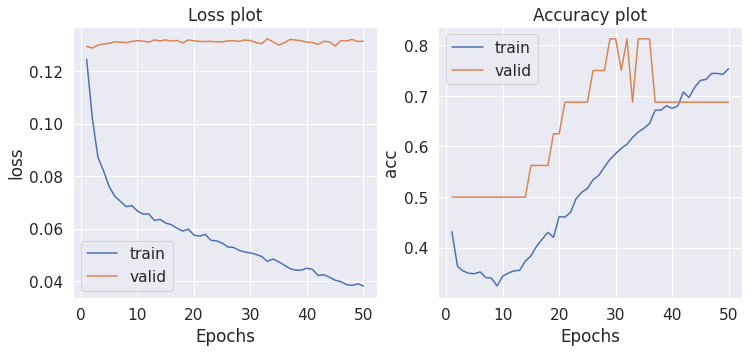

In [15]:
# plot the model loss and accuracy
train_loss = history1.history['loss']
train_acc = history1.history['accuracy']

valid_loss = history1.history['val_loss']
valid_acc = history1.history['val_accuracy']

x = [(i+1) for i in range(len(train_loss))]

f,ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(x, train_loss)
ax[0].plot(x, valid_loss)
ax[0].set_title("Loss plot")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'valid'])


ax[1].plot(x, train_acc)
ax[1].plot(x, valid_acc)
ax[1].set_title("Accuracy plot")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("acc")
ax[1].legend(['train', 'valid'])

plt.show()

Precision:0.9313
Recall score:0.7641

Confusion Matrix:
 AxesSubplot(0.125,0.125;0.62x0.755)


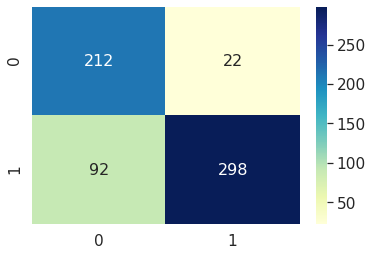

In [16]:
pred = np.round(model.predict(test_images,steps=test_steps))
print("Precision:{:.4f}\nRecall score:{:.4f}\n".format(precision_score(test_labels,pred),recall_score(test_labels,pred)))
print("Confusion Matrix:\n",sns.heatmap(confusion_matrix(test_labels,pred), annot=True, annot_kws={"size": 16}, cmap='YlGnBu', fmt='d'))

## That's quite good performance, fork and make this even better!